In [5]:
from useful_functions import crypto_raw_to_pandas
import pandas as pd
import numpy as np

In [6]:
crypto_data_filepath = "btc_and_price_data/"
crypto_data_filename = "chainlink_crypto_prices_2025-10-30.jsonl"
market_data_filepath = "btc_and_price_data/"
crypto_symbol = "btc/usd"

all_coin_df = crypto_raw_to_pandas(f"{crypto_data_filepath}{crypto_data_filename}")
coin_df = all_coin_df[all_coin_df['symbol'] == crypto_symbol].sort_values(by="unix_timestamp").reset_index(drop=True)

np.float64(-1.8307251917032873e-07)

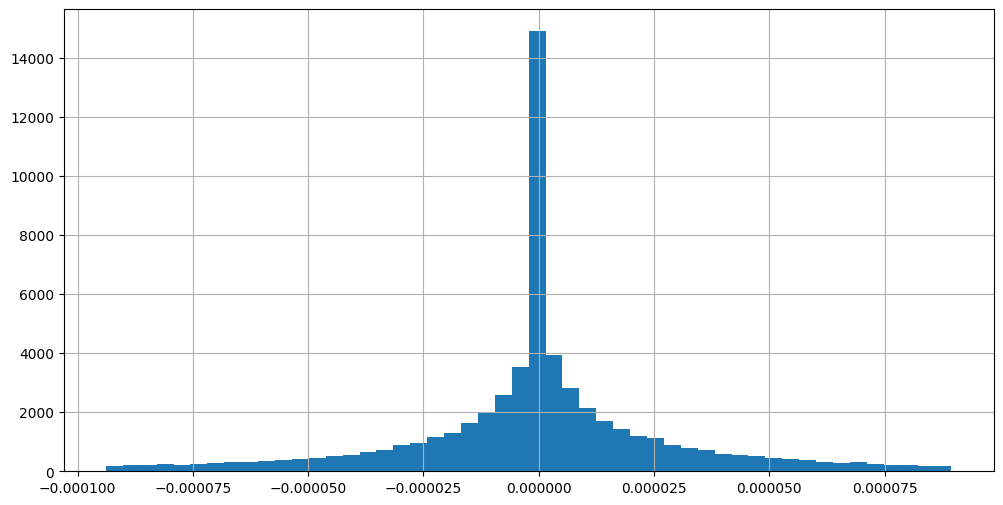

In [63]:
returns: pd.Series = (np.log(coin_df['value']) - np.log(coin_df['value'].shift(1))).dropna()

lower_bound = returns.quantile(0.05)
upper_bound = returns.quantile(0.95)

# Filter the Series to exclude values outside these bounds
returns = returns[(returns >= lower_bound) & (returns <= upper_bound)]

returns.hist(bins=50, figsize=(12,6))
returns.mean()

### Plotting my fit t distribution

In [64]:
nu, mu, sigma = t.fit(returns)

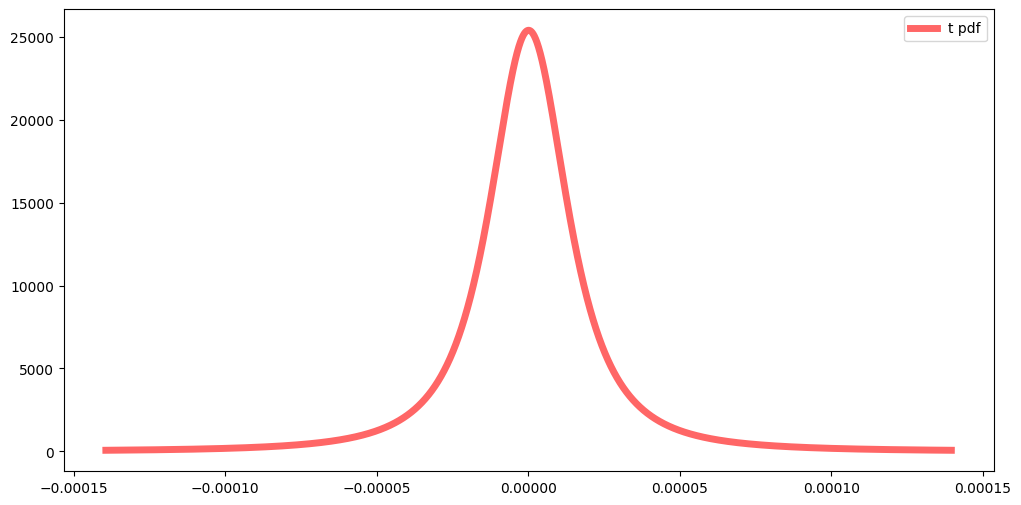

In [79]:
import numpy as np
from scipy.stats import t, norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12,6))

df = nu
x = np.linspace(t.ppf(0.005, df, loc=mu, scale=sigma),
                t.ppf(0.995, df, loc=mu, scale=sigma), 10000)
ax.plot(x, t.pdf(x, df, loc=mu, scale=sigma), 'r-', lw=5, alpha=0.6, label='t pdf')

# plt.vlines(t.ppf(0.05, df, loc=mu, scale=sigma), 0, 20, colors="r")

plt.legend()

### 15 min returns

(np.float64(-2.9667228039371676e-05),
 np.float64(0.010091462206278391),
 np.float64(-0.3269211709762341))

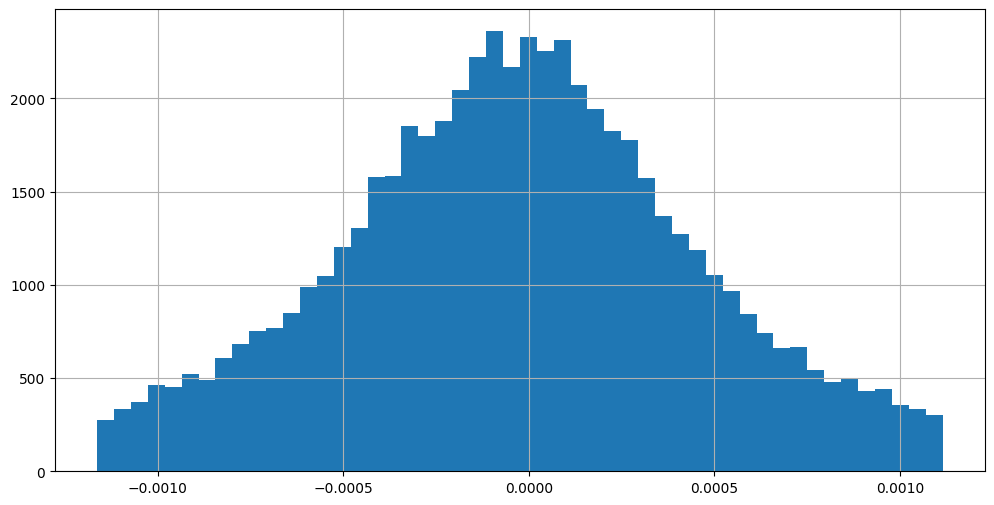

In [82]:
returns_15: pd.Series = (np.log(coin_df['value']) - np.log(coin_df['value'].shift(60))).dropna()

lower_bound = returns_15.quantile(0.05)
upper_bound = returns_15.quantile(0.95)

# Filter the Series to exclude values outside these bounds
returns_15 = returns_15[(returns_15 >= lower_bound) & (returns_15 <= upper_bound)]

returns_15.hist(bins=50, figsize=(12,6))
returns_15.mean(), returns_15.skew(), returns_15.kurt()

In [19]:
np.sqrt(returns.std()**2*3.154e+7), returns.skew(), returns.kurt()

(np.float64(0.37866425271568227),
 np.float64(-0.34642446000312516),
 np.float64(46.56510530312552))

In [13]:
from scipy.stats import t

nu, mu, sigma = t.fit(returns)
nu, mu, sigma

(np.float64(1.9882049304606118),
 np.float64(2.0101435113003494e-07),
 np.float64(1.946112399552947e-05))

In [32]:
import datetime as dt
unix_start_time = 1_761_786_000_000
unix_end_time = unix_start_time + 900_000 # end time
limited_coin_df = coin_df[(coin_df['timestamp']>=dt.datetime.utcfromtimestamp(unix_start_time//1000)) & (coin_df['timestamp']<=dt.datetime.utcfromtimestamp(unix_end_time//1000))]
limited_returns: pd.Series = (np.log(limited_coin_df['value']) - np.log(limited_coin_df['value'].shift(1))).dropna()
np.sqrt(limited_returns.std()**2*3.154e+7), limited_returns.skew(), limited_returns.kurt()

/var/folders/1d/dkqlxg7d3yv8ccfw3vkrtnsm0000gn/T/ipykernel_69833/2522148029.py:4: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  limited_coin_df = coin_df[(coin_df['timestamp']>=dt.datetime.utcfromtimestamp(unix_start_time//1000)) & (coin_df['timestamp']<=dt.datetime.utcfromtimestamp(unix_end_time//1000))]


(np.float64(0.2801791558262076),
 np.float64(0.8110714339021281),
 np.float64(20.90935736153375))

In [33]:
nu, mu, sigma = t.fit(limited_returns)
nu, mu, sigma

(np.float64(1.9883956190471306),
 np.float64(-3.7932343168604273e-07),
 np.float64(1.6299660576582788e-05))

In [35]:
np.sqrt(1.6299660576582788e-05**2 * 3.154e+7)

np.float64(0.09153968323693498)

### Trying T-distribution pricing

In [37]:
from useful_functions import binary_price

In [ ]:
import numpy as np
from scipy.stats import norm
from math import factorial, sqrt, exp, log

def bs_call(S, K, r, sigma, tau):
    if tau <= 0:
        return max(S-K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma*sigma)*tau) / (sigma*sqrt(tau))
    d2 = d1 - sigma*sqrt(tau)
    return S * norm.cdf(d1) - K * exp(-r*tau) * norm.cdf(d2)

def merton_call(S, K, r, sigma, tau, lam, muJ, sigmaJ, n_max=None):
    """
    Merton's jump-diffusion price: sum_{n=0}^inf Poisson(n; lam*tau) * BS(S, K, r_n, sigma_n)
    r_n is same r but drift adjusted via lambda*kappa accounted in forward; simplest implement via conditional log-mean
    """
    kappa = np.exp(muJ + 0.5*sigmaJ*sigmaJ) - 1.0
    lam_tau = lam * tau
    # choose truncation
    if n_max is None:
        n_max = int(max(50, np.ceil(lam_tau + 10*np.sqrt(lam_tau + 1e-12))))
    price = 0.0
    for n in range(n_max+1):
        # Poisson weight
        w = np.exp(-lam_tau) * (lam_tau**n) / factorial(n)
        # adjusted volatility over tau:
        sigma_n = np.sqrt(sigma*sigma + (n * sigmaJ*sigmaJ) / tau)
        # adjusted forward: incorporate extra mean from jumps
        mu_adj = -0.5 * sigma*sigma - lam * kappa + (n * muJ) / tau
        # Use BS with forward drift r (already risk-neutral), but simpler: compute equivalent BS using:
        # we can instead use S * exp(( - lam*kappa )*tau + n*muJ) as effective forward; easier: use d1,d2 derived for conditional lognormal
        # We'll use BS with adjusted initial S' = S * exp(n*muJ - lam*kappa*tau)
        S_tilde = S * np.exp(n*muJ - lam*kappa * tau)
        c_bs = bs_call(S_tilde, K, r, sigma_n, tau)
        price += w * c_bs
    return price

# Example:
S=100; K=100; r=0.01; tau=30/365.0
sigma=0.12; lam=0.5; muJ=-0.1; sigmaJ=0.2
print("Merton price:", merton_call(S,K,r,sigma,tau,lam,muJ,sigmaJ))


In [50]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from math import ceil, sqrt, factorial

def poisson_weights(lam_dt, n_max):
    n = np.arange(n_max+1)
    # use log to avoid overflow then exp:
    logw = -lam_dt + n * np.log(lam_dt) - np.log(np.array([factorial(ni) for ni in n]))
    return np.exp(logw)

def merton_logpdf_vectorized(x, dt, mu_diff, sigma, lam, muJ, sigmaJ, n_max=None):
    """
    Vectorized log-pdf of Merton jump-diffusion for array x (log-returns).
    Returns array of log pdfs for each x_i.
    """
    x = np.asarray(x)
    lam_dt = lam * dt
    if n_max is None:
        # choose truncation so tail is tiny
        n_max = int(max(50, ceil(lam_dt + 12*sqrt(lam_dt + 1e-12))))
    n = np.arange(n_max+1)
    w = poisson_weights(lam_dt, n_max)            # shape (n_max+1,)
    # mean and var for each n (scalars per n)
    kappa = np.exp(muJ + 0.5*sigmaJ*sigmaJ) - 1.0
    m_dt = (mu_diff - 0.5*sigma*sigma - lam * kappa) * dt
    var0 = sigma*sigma * dt

    mus = m_dt + n * muJ                             # shape (n_max+1,)
    vars = var0 + n * (sigmaJ*sigmaJ)                # shape (n_max+1,)

    # Compute normal pdfs: for vector x (M) and n (N), we want MxN matrix of densities
    # We'll compute logpdfs for numerical stability
    # Expand dims for broadcasting
    x_col = x[:, None]        # (M,1)
    mu_row = mus[None, :]     # (1,N)
    var_row = vars[None, :]   # (1,N)
    # log pdf of normal
    log_pdf = -0.5 * (np.log(2*np.pi*var_row) + ((x_col - mu_row)**2) / var_row)  # (M,N)
    # add log weights
    logw_row = np.log(w)[None, :]  # (1,N)
    # log-sum-exp across n to get log f(x)
    # stable log-sum-exp: logsumexp(logw + log_pdf, axis=1)
    a = logw_row + log_pdf
    a_max = np.max(a, axis=1, keepdims=True)   # (M,1)
    log_sum = a_max + np.log(np.sum(np.exp(a - a_max), axis=1, keepdims=True))  # (M,1)
    return log_sum.ravel()   # (M,)

def negative_log_likelihood(theta, x, dt, n_max=None):
    """
    theta = [mu_diff, log_sigma, log_lam, muJ, log_sigmaJ]
    we parametrize positive quantities on log-scale for stability
    """
    mu_diff = theta[0]
    sigma = np.exp(theta[1])
    lam = np.exp(theta[2])
    muJ = theta[3]
    sigmaJ = np.exp(theta[4])

    logpdfs = merton_logpdf_vectorized(x, dt, mu_diff, sigma, lam, muJ, sigmaJ, n_max=n_max)
    # negative log-likelihood
    nll = -np.sum(logpdfs)
    return nll

def fit_merton_mle(x, dt=1/252.0, init=None, bounds=None, n_max=None):
    x = np.asarray(x)
    # initial guesses if not provided
    if init is None:
        # Fit plain normal to get mean/variance
        m_hat = np.mean(x) / dt       # crude annualized drift estimate
        s_hat = np.std(x) / np.sqrt(dt)  # crude annualized sigma
        init = np.array([m_hat, np.log(max(s_hat, 1e-6)), np.log(0.5), -0.05, np.log(0.2)])
    # bounds: mu_diff free, logs unconstrained, muJ free, etc.
    if bounds is None:
        bounds = [
            (None, None),         # mu_diff
            (np.log(1e-6), np.log(5.0)),   # log_sigma
            (np.log(1e-8), np.log(500.0)), # log_lam
            (None, None),         # muJ
            (np.log(1e-6), np.log(3.0))    # log_sigmaJ
        ]
    res = minimize(negative_log_likelihood, init, args=(x, dt, n_max),
                   method='L-BFGS-B', bounds=bounds,
                   options={'maxiter':1000, 'ftol':1e-9})
    if not res.success:
        print("Optimization warning:", res.message)
    theta_hat = res.x
    mu_diff_hat = theta_hat[0]
    sigma_hat = np.exp(theta_hat[1])
    lam_hat = np.exp(theta_hat[2])
    muJ_hat = theta_hat[3]
    sigmaJ_hat = np.exp(theta_hat[4])
    return {
        'mu_diff': mu_diff_hat, 'sigma': sigma_hat,
        'lam': lam_hat, 'muJ': muJ_hat, 'sigmaJ': sigmaJ_hat,
        'nll': res.fun, 'success': res.success, 'optim_res': res
    }


In [51]:
res = fit_merton_mle(returns, dt=1/3.154e+7)
print(res)

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log method